### **Problem Statement:** 
We aim to solve **1D steady-state flow problems** in homogeneous porous media using the **Physics-Informed Neural Networks (PINN)** approach for solving PDEs, implemented with the JAX library. The objective is to compute the hydraulic head, h(x), over a 1D domain based on Darcy's law.


### **Domain**:
$$ 
\Omega = \{ x \mid 0 \leq x \leq L \}
$$



### **Governing Equation**:
The 1D steady-state flow in heterogenous porous media is governed by Darcy's law as follows:
$$ 
\frac{\partial}{\partial x} \left( K \frac{\partial h}{\partial x} \right) = 0, \quad \text{in } \Omega.
$$ 

Lets assume hydraulic conductivity varies as a non-negative convex function as follows:
$$ 
K(x) = (x + 0.5)^2
$$ 



### **Boundary Conditions**

**Dirichlet Boundary Conditions** (Prescribed pressure on the left and right boundaries):  
$$ 
h(0) = h_1, \quad h(L) = h_2.
$$



### **Objective**:
We solve this problem using Physics-Informed Neural Networks (PINN) to predict the head, h(x), across the domain and compare it with the analytical solution for the same configuration.


---
**Developed by**:
Lal Mamud, Postdoc - Subsurface Modeler, Environmental Subsurface Science Group, Energy & Environment Division, Pacific Northwest National Laboratory, Richland, WA, USA.

**Mentors**:
Maruti K. Mudunuru and Satish Karra

---


## Import required Python libraries 

In [4]:
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap, jacfwd, jacrev
import optax
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## 2. Define Domain and Boundary Conditions, Generate Collocation Points

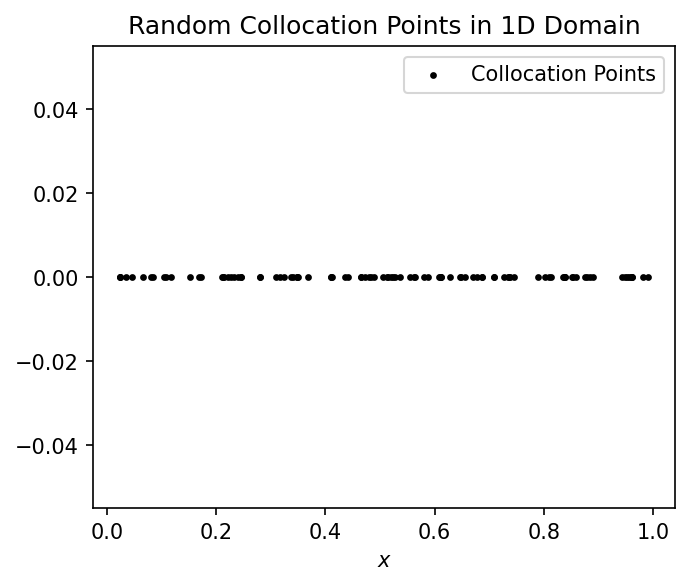

In [5]:
xmin = 0.0  # Left boundary of the domain
xmax = 1.0  # Right boundary of the domain

lb_head = 1  # Head at the left boundary
rb_head = 0.9  # Head at the right boundary
bcs = [lb_head, rb_head]  # Boundary conditions as a list

n_colloc = 100  # Number of collocation points

# Generate random collocation points within the domain
key = jax.random.PRNGKey(0)  # Random seed
#x_colloc = jnp.linspace(xmin, xmax, n_colloc).reshape(-1, 1)
x_colloc = jax.random.uniform(key, shape=(n_colloc, 1), minval=xmin, maxval=xmax)

# Plot the random collocation points
plt.figure(figsize = (5, 4), dpi = 150)
plt.scatter(x_colloc, jnp.zeros_like(x_colloc), color='black', label='Collocation Points', s=5)
plt.xlabel('$x$')
#plt.ylabel('Random Points (Plotted on $y=0$)')
plt.title('Random Collocation Points in 1D Domain')
plt.legend()

## 3. Define PDE Residual

In [8]:
# PDE Residual for 1D Darcy's Flow
def pde_residual_1d_darcy(x, h):
    """
    Compute the PDE residual for Darcy's flow.

    Args:
        h Lambda function representing the neural network solution h(x).
        x: Collocation points (array of shape Nx1).
    
    Returns:
        pde_res: PDE residual (array of shape Nx1).
    """
    K = lambda x: ((x + 0.5)**2)  #  calculate K

    h_x = lambda x: K(x) * vmap(jacfwd(h))(x)  # First derivative
    
    h_xx = lambda x: vmap(jacrev(h_x))(x)  # Second derivative
    
    pde_res = h_xx(x).reshape(-1, 1)
    
    return pde_res

## 4. Define Neural Network Architecture

In [9]:
# Define Neural Network Architecture and Initialization
def neural_net(params, coord):
    """
    Forward pass through the neural network.

    Args:
        params: Neural network parameters (list of weights and biases).
        coord: Input coordinates (array of shape Nx1).
    
    Returns:
        h_nn: Output of the neural network.
    """
    for w, b in params:
        h_nn = jnp.dot(coord, w) + b
        coord = jnp.tanh(h_nn)  # Activation function
    return h_nn


def init_mlp(layers, key):
    """
    Initialize the neural network using Xavier initialization.

    Args:
        layers: List defining the number of nodes in each layer (e.g., [1, 50, 50, 1]).
        key: Random key for initialization.
    
    Returns:
        params: Initialized weights and biases for the network.
    """
    params = []
    for i in range(len(layers) - 1):
        key, subkey = random.split(key)
        bound = jnp.sqrt(6. / (layers[i] + layers[i+1]))
        weights = random.uniform(subkey, (layers[i], layers[i+1]), minval=-bound, maxval=bound)
        biases = jnp.zeros(layers[i+1])
        params.append((weights, biases))
    return params

## 5. Define Loss Function

In [11]:
# Loss Function
def loss_func(params, x, bcs):
    """
    Compute the total loss for the PINN.

    Args:
        params: Neural network parameters.
        x: Collocation points (array of shape Nx1).
        bcs: Boundary conditions [left_head, right_head].
    
    Returns:
        loss: Total loss (scalar).
    """

    h = lambda x: neural_net(params, x)
    
    # PDE residual loss
    #pde_res = pde_residual_1d_darcy(params, x)
    pde_res = pde_residual_1d_darcy(x, h)
    
    pde_loss = jnp.mean(pde_res**2)  # Ensure this is scalar

    # Boundary condition loss
    left_bc_loss = (h(xmin) - bcs[0])**2
    
    right_bc_loss = (h(xmax) - bcs[1])**2
    
    bc_loss = left_bc_loss + right_bc_loss  # Ensure scalar addition

    # Total loss
    loss = pde_loss + bc_loss
    
    return jnp.sum(loss)  # Return scalar

## 6. Define Hyperparameters and Training Loop
This cell contains the training loop for the Physics-Informed Neural Network (PINN). It includes functions and code to update the network parameters, compute the loss, track training progress, and identify the best-performing model during the training process.

In [12]:
# Training PINN
n_hl = 3  # Number of hidden layers
n_nodes = 50  # Number of nodes per layer
lr = 1E-2  # Learning rate
epoch = 5000  # Number of epochs

layers = [1, n_nodes, 1]  # Neural network architecture
soln_type = 1  # Solution type: 0 = homogeneous, 1 = heterogeneous

# Initialize neural network
key = random.PRNGKey(1234)
params = init_mlp(layers, key)

# Initialize optimizer
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(params)



@jit
def update(params, opt_state, x):
    """
    Perform one optimization step.

    Args:
        params: Neural network parameters.
        opt_state: Optimizer state.
        x: Collocation points.
    
    Returns:
        value: Current loss.
        params: Updated parameters.
        opt_state: Updated optimizer state.
    """
    value, grads = jax.value_and_grad(loss_func)(params, x, bcs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return value, params, opt_state


# Training loop
all_losses = []
all_epochs = []
min_loss = jnp.inf
best_params = None

for i in range(epoch + 1):
    loss, params, opt_state = update(params, opt_state, x_colloc)
    all_losses.append(loss)
    all_epochs.append(i)
    if loss < min_loss:
        min_loss = loss
        best_params = params
        best_iteration = i
    if i % 100 == 0:
        print(f"Epoch {i}: Loss = {loss:.4e}")

print(f" ")
print(f"Best Model:")
print(f"Best loss: {min_loss:.4e} at iteration {best_iteration}")
print(f" ")

Epoch 0: Loss = 1.8564e+00
Epoch 100: Loss = 5.6464e-03
Epoch 200: Loss = 4.3685e-03
Epoch 300: Loss = 4.2400e-03
Epoch 400: Loss = 4.1303e-03
Epoch 500: Loss = 4.0282e-03
Epoch 600: Loss = 3.9346e-03
Epoch 700: Loss = 3.8489e-03
Epoch 800: Loss = 3.7696e-03
Epoch 900: Loss = 3.6950e-03
Epoch 1000: Loss = 3.6230e-03
Epoch 1100: Loss = 3.5507e-03
Epoch 1200: Loss = 3.4730e-03
Epoch 1300: Loss = 3.3787e-03
Epoch 1400: Loss = 3.2448e-03
Epoch 1500: Loss = 3.0224e-03
Epoch 1600: Loss = 2.6179e-03
Epoch 1700: Loss = 2.0950e-03
Epoch 1800: Loss = 1.8774e-03
Epoch 1900: Loss = 1.7460e-03
Epoch 2000: Loss = 1.6074e-03
Epoch 2100: Loss = 1.4521e-03
Epoch 2200: Loss = 1.2743e-03
Epoch 2300: Loss = 1.0747e-03
Epoch 2400: Loss = 8.6234e-04
Epoch 2500: Loss = 6.4920e-04
Epoch 2600: Loss = 4.5346e-04
Epoch 2700: Loss = 3.0119e-04
Epoch 2800: Loss = 2.0860e-04
Epoch 2900: Loss = 1.5473e-04
Epoch 3000: Loss = 1.2965e-04
Epoch 3100: Loss = 1.2469e-04
Epoch 3200: Loss = 1.1010e-04
Epoch 3300: Loss = 1.0

## 7. Plot pinn loss during training

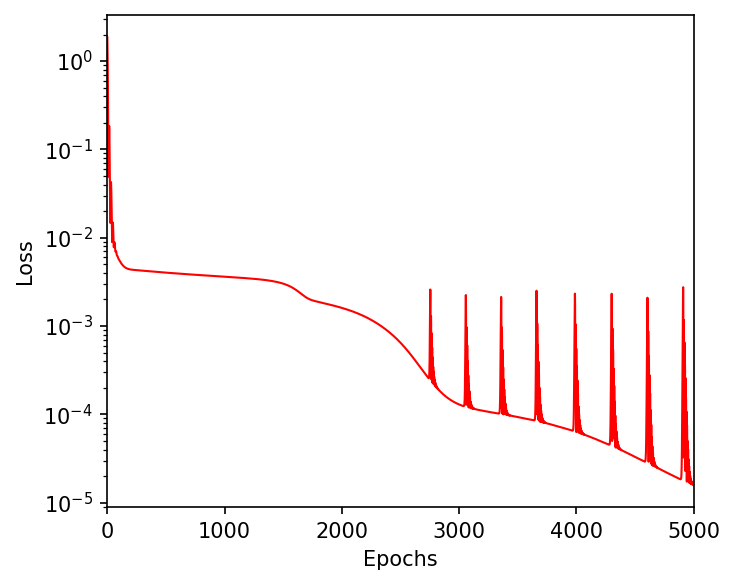

In [13]:
def plot_pinn_training(all_losses, all_epochs):
    plt.figure(figsize = (5, 4), dpi = 150)
    plt.semilogy(all_epochs, all_losses, '-r', markersize = 4, linewidth = 1.0)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.legend(prop={"size": fontsize_legend}, loc="best")
    plt.xlim(min(all_epochs), max(all_epochs))
    plt.tight_layout()
    
plot_pinn_training(all_losses, all_epochs)

## 8. PINN prediction and plotting results

In [14]:
nx = 20
x = np.linspace(xmin, xmax, nx)
x = np.linspace(xmin, xmax, nx).reshape(-1, 1)  # Reshape to (nx, 1) to match neural_net input


# Predict head using the trained neural network
h_pinn = neural_net(best_params, x)  # Output will be (nx, 1)
print(h_pinn)

[[0.9996199 ]
 [0.9853598 ]
 [0.9735157 ]
 [0.9635799 ]
 [0.9551498 ]
 [0.9479128 ]
 [0.94162846]
 [0.9361133 ]
 [0.9312273 ]
 [0.9268633 ]
 [0.9229392 ]
 [0.9193903 ]
 [0.91616553]
 [0.9132237 ]
 [0.91053075]
 [0.9080579 ]
 [0.90578055]
 [0.90367705]
 [0.901728  ]
 [0.89991575]]


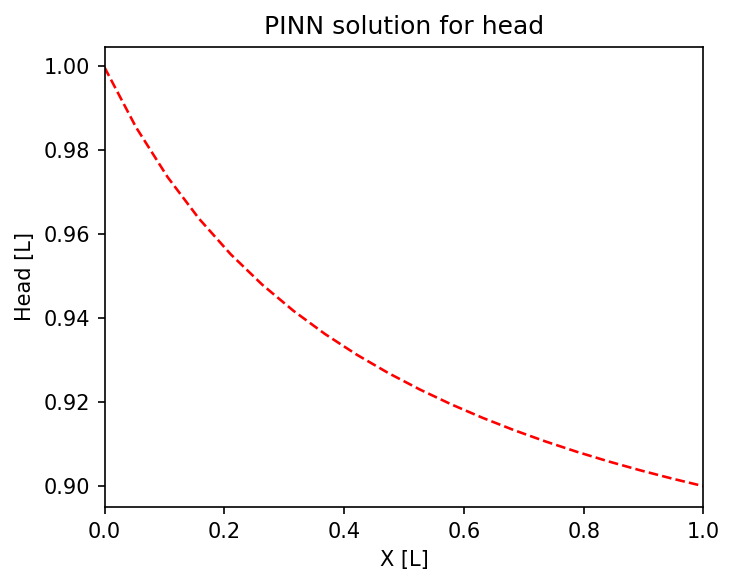

In [15]:
def plot_head_solutions(coords, pinn_head):
    plt.figure(figsize = (5, 4), dpi = 150)
    #plt.plot(coords, head_exact, color='Black', linestyle='-', linewidth = 1.25, label="Analytical")
    plt.plot(coords, pinn_head, '--', color='red', markersize = 4,  markerfacecolor = 'green', linewidth = 1.25, label="PINN")
    plt.xlabel("X [L]")
    plt.ylabel("Head [L]")
    plt.title("PINN solution for head")
    plt.xlim(np.min(coords), np.max(coords))
    plt.tight_layout()
plot_head_solutions(x, h_pinn )

## 9. Solution verifications

In [16]:
# exact solution for this configuration
def exact_solution_hetero(x_coords):
    head_exact = 0.075 / (x_coords + 0.5) + 1 - (0.075 / 0.5)
    return head_exact

h_exact = exact_solution_hetero(x)
print(h_exact)

[[1.        ]
 [0.98571429]
 [0.97391304]
 [0.964     ]
 [0.95555556]
 [0.94827586]
 [0.94193548]
 [0.93636364]
 [0.93142857]
 [0.92702703]
 [0.92307692]
 [0.9195122 ]
 [0.91627907]
 [0.91333333]
 [0.9106383 ]
 [0.90816327]
 [0.90588235]
 [0.90377358]
 [0.90181818]
 [0.9       ]]


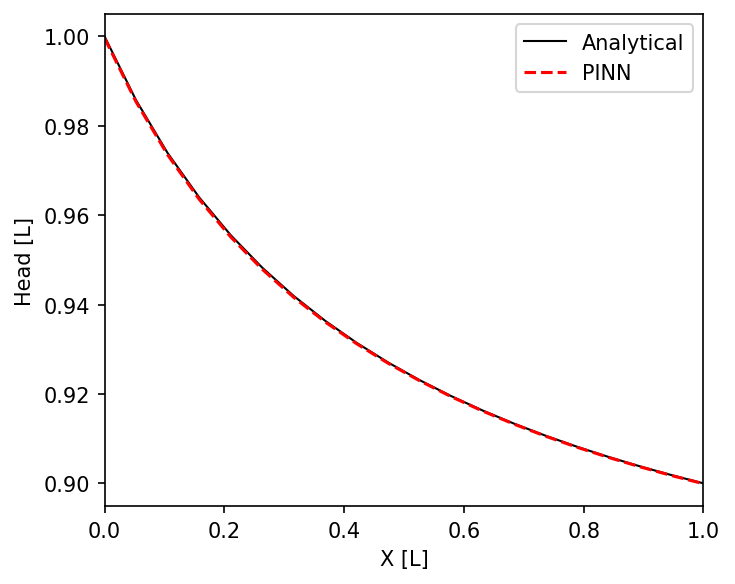

In [17]:
def plot_head_solutions_as_pinn(coords, pinn_head, exact_head):
    plt.figure(figsize = (5, 4), dpi = 150)
    plt.plot(coords, exact_head, color='Black', linestyle='-', linewidth = 1.0, label="Analytical")
    plt.plot(coords, pinn_head, '--', color='red', markersize = 4,  markerfacecolor = 'green', linewidth = 1.5, label="PINN")
    plt.xlabel("X [L]")
    plt.ylabel("Head [L]")
    plt.legend(loc="upper right")
    plt.xlim(np.min(coords), np.max(coords))
    plt.tight_layout()
plot_head_solutions_as_pinn(x, h_pinn, h_exact)

## 10. Error analysis between the analytical solution and PINN prediction

In [18]:
# Analytical solution and PINN predictions are already 1D
analytical_Pr = h_exact.flatten()  # Flatten the analytical solution (if necessary)
pinn_Pr = h_pinn.flatten()  # Flatten the PINN predictions (if necessary)

# Perform regression
reg = LinearRegression()
reg.fit(analytical_Pr.reshape(-1, 1), pinn_Pr)  # Fit the model

# Predict using the regression model
y_pred = reg.predict(analytical_Pr.reshape(-1, 1))

# Calculate R^2 score
r2 = r2_score(pinn_Pr, y_pred)

# Calculate RMSE
mse = mean_squared_error(pinn_Pr, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print results
print(f"R^2 Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

R^2 Score: 1.0000
Root Mean Squared Error (RMSE): 0.0001


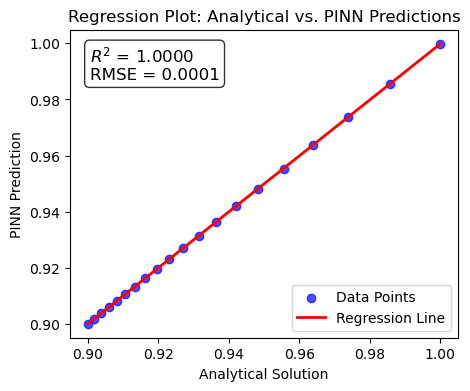

In [22]:
#%% Plotting Regressionplt.figure(figsize = (5, 4), dpi = 150)
plt.figure(figsize=(5, 4))
plt.scatter(analytical_Pr, pinn_Pr, label="Data Points", color="blue", alpha=0.7)
plt.plot(analytical_Pr, y_pred, label="Regression Line", color="red", linewidth=2)

# Add annotations for RMSE and R^2
plt.text(
    0.05,
    0.95,
    f"$R^2$ = {r2:.4f}\nRMSE = {rmse:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.xlabel("Analytical Solution")
plt.ylabel("PINN Prediction")
plt.title("Regression Plot: Analytical vs. PINN Predictions")
plt.legend(loc="lower right")
plt.show()

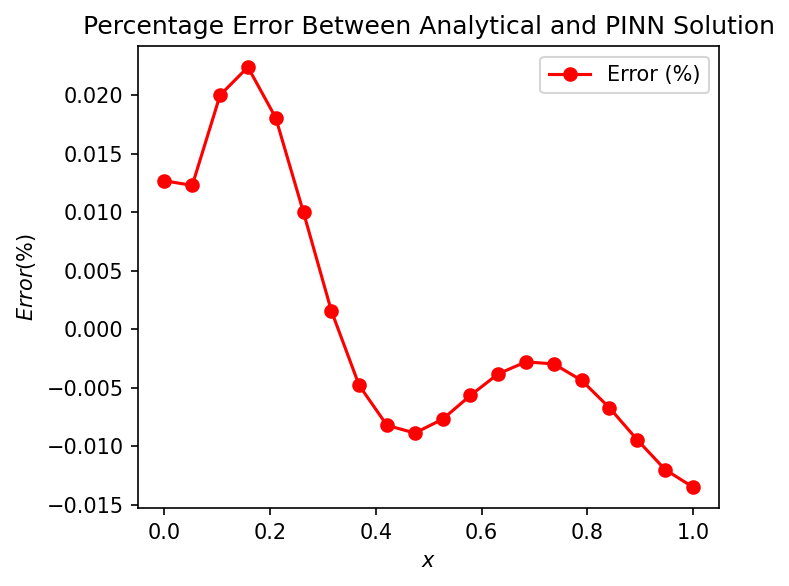

In [23]:
#%% Plotting Error
# Calculate percentage error
error_percentage = 100 * (analytical_Pr - pinn_Pr) / analytical_Pr
plt.figure(figsize = (5, 4), dpi = 150)
plt.plot(x, error_percentage, label="Error (%)", color="red", marker="o")
plt.xlabel("$x$")
plt.ylabel("$Error (\%)$")
plt.title("Percentage Error Between Analytical and PINN Solution")
plt.legend()
plt.show()